# 1. Naive Bayes

For this problem, first you have create a user-defined fuction for Bernoulli naive Bayes. Then, train a classifier using this function.

For this problem, use the MAGIC Gamma Telescope data set.

The included variabes in this dataset are as follows. 
1. fLength: continuous # major axis of ellipse [mm] 
2. fWidth: continuous # minor axis of ellipse [mm] 
3. fSize: continuous # 10-log of sum of content of all pixels [in #phot] 
4. fConc: continuous # ratio of sum of two highest pixels over fSize [ratio] 
5. fConc1: continuous # ratio of highest pixel over fSize [ratio] 
6. fAsym: continuous # distance from highest pixel to center, projected onto major axis [mm] 
7. fM3Long: continuous # 3rd root of third moment along major axis [mm] 
8. fM3Trans: continuous # 3rd root of third moment along minor axis [mm] 
9. fAlpha: continuous # angle of major axis with vector to origin [deg] 
10. fDist: continuous # distance from origin to center of ellipse [mm] 
11. class: g,h # gamma (signal), hadron (background)

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

# data load
magic=pd.read_csv('https://drive.google.com/uc?export=download&id=1AoCh22pmLHhdQtYdYUAJJqOCwF9obgVO', sep='\t')

X=magic[magic.columns[:-1]].values
y=magic['class'].values

# data partition
trainX,testX,trainY,testY=train_test_split(X,y,stratify=y,test_size=0.2,random_state=11)

(1) Complete the following user-defined function for Bernoulli naive Bayes. 

In [2]:
def BNB(X,y,alpha=1):
    ######## BERNOULLI NAIVE BAYES ########
    # INPUT 
    # X: n by p array (n=# of observations, p=# of input variables)
    # y: output (len(y)=n, categorical variable)
    # alpha: smoothing paramater
    # OUTPUT
    # pmatrix: 2-D array(list) of size c by p with the probability p_ij=P(x_j=1|y_j=i) (i=class, j=feature) 
    #         where c is number of unique classes in y
        
    # TODO: Bernoulli NB
    
    n, p = X.shape
    Class = sorted(list(set(y))) # sorted used for calculating unique classes in y ,for making list sequentially
    c = len(Class)
    Nc = [] #the number of samples in Class[k]
    Ntic = [[0 for j in range(p)] for i in range(c)] # number of samples with xi =1 in class C
    
    for i in range(c):        
        Nc.append(list(y).count(Class[i]))
    
    for i in range(p):
        for k in range(c):    
            for j in range(n):
                if X[:,i][j] == 1 and y[j] == Class[k]:
                    Ntic[k][i] = Ntic[k][i]+1
      
    pmatrix = [[0 for j in range(p)] for i in range(c)]
    
    for i in range(p):
        for j in range(c):
            pmatrix[j][i] = (Ntic[j][i]+alpha)/(Nc[j]+2*alpha)
    
    return pmatrix 

(2) First, you have to binarize training set (trainX) of MAGIC Gamma Telescope data set. Each column is converted to binary variable based on the average value. If a value is greater than average, set a value as 1. Otherwise, set a value as 0. Then, using new binarized dataset, calculate $p_{ij}$ (i=class,j=feature) with alpha=1. 

In [3]:
n,p = trainX.shape

mean = []
for i in range(p):
    mean.append(np.mean(trainX[:,i]))
    
Num2 = [0 for i in range(p)]
for i in range(p):
    for j in range(n):
        if trainX[:,i][j] >= mean[i]:
            trainX[:,i][j] = 1
            Num2[i] = Num2[i]+1
        else:
            trainX[:,i][j] = 0
            
Likelihood = BNB(trainX,trainY)
Likelihood

Result = pd.DataFrame(data = Likelihood,index = ['Class g','Class h'])
Result.transpose()



,Class g,Class h
0,0.283948,0.460202
1,0.265707,0.398729
2,0.400993,0.473281
3,0.447912,0.463191
4,0.433624,0.453475
5,0.660418,0.527093
6,0.610762,0.508408
7,0.504054,0.497010
8,0.235103,0.674701
9,0.460681,0.534193


(3) Based on the calculated p_ij, calculate probability of class g for each test sample (testX) and calculate accuracy for testX with varying cutoff (To binarize testX, use the mean of trainX). Prior probabilities of classes are proportional to ratios of classes in training set. cutoff ∈{0.1,0.15,0.2,0.25,…,0.95}. Draw a line plot (x=cutoff, y=accuracy). 

In [4]:
# for setting testX by average of trainX
trainX,testX,trainY,testY=train_test_split(X,y,stratify=y,test_size=0.2,random_state=11) 
# only this part executed two time because testX changed result is changed so this line added

n,p = testX.shape
Num = [0 for i in range(p)]

for i in range(p):
    for j in range(len(testX)):
        if testX[:,i][j] >= mean[i]:
            testX[:,i][j] = 1
            Num[i] = Num[i]+1
        else:
            testX[:,i][j] = 0
    

In [5]:
# for calculating prior probablities and P(x)
Prob_prior = [0,0]
Prob_prior[0] = list(trainY).count('g')/len(trainY)
Prob_prior[1] = 1 - Prob_prior[0]

Prob_X1 = [0 for i in range(p)] # this is when Xi = 1 probablity 

for i in range(p):
    Prob_X1[i] = Num[i]/len(testY)

Prob_XCk = [0 for i in range(len(testY))] # For P(X|C='g')
Prob_XCk2 = [0 for i in range(len(testY))] # For P(X|C='h')

for i in range(len(testY)):
    prob = 1
    prob1 = 1

    for j in range(p):
        if testX[i][j] == 1:
            prob = prob * Likelihood[0][j]
            prob1 = prob1 * Likelihood[1][j]
        else:
            prob = prob * (1-Likelihood[0][j])
            prob1 = prob1 *(1-Likelihood[1][j])
            
    Prob_XCk[i] = prob 
    Prob_XCk2[i] = prob1

In [6]:
# P(Ck|X) ~~ P(Ck) * P(X|Ck) 
# SO P(C='g'|X) = P(C='g')*P(X|C='g') / (P(C='g')*P(X|C='g') + P(C='h')*P(X|C='h'))
TargetProb = [0 for i in range(len(testY))]

for i in range(len(testY)):
        TargetProb[i] = Prob_prior[0]*Prob_XCk[i]/(Prob_prior[0]*Prob_XCk[i] + Prob_prior[1]*Prob_XCk2[i])



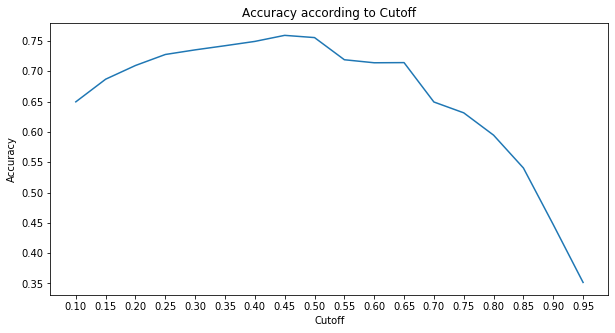

In [7]:
TargetValue = []

cutoff = []
for i in range(10,100,5):
    cutoff.append(i/100)

Accuracy = []
for i in cutoff:
    Num1 = 0 # for reset Number of correctly predicted samples
    for j in range(len(testY)):
        if TargetProb[j] >= i:
            TargetValue.append('g')
        elif TargetProb[j] < i:
            TargetValue.append('h')
            
        if TargetValue[j] == testY[j]:
            Num1 = Num1+1
                   
    Accuracy.append(Num1/len(testY))
    TargetValue = []
    
plt.figure(figsize=(10,5))
plt.plot(cutoff,Accuracy)
plt.title('Accuracy according to Cutoff')
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.xticks(cutoff)

plt.show()




## 2. Decision Tree
The aim of the given data set is to predict annual income of people based on the following factors.
-	age:  the age of an individual
-	capital-gain: capital gains for an individual
-	capital-loss: capital loss for an individual
-	hours-per-week: the hours an individual has reported to work per week
-	sex: 1 if male, 0 if female
-	native-country: 1 if USA, 0 if others
-	workclass_[#]: 1 if an individual belongs to workclass # otherwise 0 (eg. Workclass_Private is 1 if an individual works for private companies)
-	education_[#]: 1 if an individual’s education level is # otherwise 0(education level: Graduate > 4-year university > “<4-year university” > High school > “<High school” > Preschool)
-	marital-status_[#] 1 if an individual’s marital status is # otherwise 0 (Married-civ-spouse corresponds to a civilian spouse while Married-AF-spouse is a spouse in the Armed Forces)
-	occupation_[#]: 1 if an individual’s occupation is # otherwise 0. 
-	race_[#]: 1 if an individual’s race is #, otherwise 0

Target is ‘income’ (“>50K” or “<=50K”)

fnlwgt represents the number of people the census believes the entry represents, which is not used in training. 


In [8]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline
income=pd.read_csv('https://drive.google.com/uc?export=download&id=13HzPLzSDfSwOhvpYOrRSWPMoXzGwYQPx')

In [9]:
del income['fnlwgt']

(1) Train a decision tree with the setting that max_depth=3, min_samples_split=100, min_samples_leaf=50 using entropy. Then, calculate overall accuracy, accuracy of class ">50K", and accuracy of class "<=50K".

In [10]:
t1 = DecisionTreeClassifier(criterion = "entropy",max_depth = 3, min_samples_split = 100, min_samples_leaf = 50)

X = income[income.columns[:-1]].values
y = income['income'].values
t1.fit(X,y)
y_pred = t1.predict(X)

Overall = t1.score(X,y)

NumOfFirst = 0
NumOfSecond = 0
predNumOfFirst = 0
predNumOfSecond = 0
Num=0
for i in range(len(y)):
    if y[i] == ">50K":
        NumOfFirst = NumOfFirst + 1
        if y_pred[i] == ">50K":
            predNumOfFirst = predNumOfFirst + 1
    else:
        NumOfSecond = NumOfSecond + 1
        if y_pred[i] != ">50K":
            predNumOfSecond = predNumOfSecond + 1
    if y[i]==y_pred[i]:
        Num = Num+1
        
Overall, predNumOfFirst/NumOfFirst, predNumOfSecond/NumOfSecond

(0.7975454131128329, 0.18980392156862744, 0.9990896479972255)

(3) Draw the trained tree

[Text(334.8, 475.65000000000003, 'marital-status_Married-civ-spouse <= 0.5\nentropy = 0.81\nsamples = 30718\nvalue = [23068, 7650]\nclass = <=50K'),
 Text(167.4, 339.75, 'capital-gain <= 7073.5\nentropy = 0.362\nsamples = 16379\nvalue = [15250, 1129]\nclass = <=50K'),
 Text(83.7, 203.85000000000002, 'age <= 27.5\nentropy = 0.295\nsamples = 16079\nvalue = [15241, 838]\nclass = <=50K'),
 Text(41.85, 67.94999999999999, 'entropy = 0.06\nsamples = 6155\nvalue = [6112, 43]\nclass = <=50K'),
 Text(125.55000000000001, 67.94999999999999, 'entropy = 0.403\nsamples = 9924\nvalue = [9129, 795]\nclass = <=50K'),
 Text(251.10000000000002, 203.85000000000002, 'education_High school <= 0.5\nentropy = 0.194\nsamples = 300\nvalue = [9, 291]\nclass = >50K'),
 Text(209.25, 67.94999999999999, 'entropy = 0.094\nsamples = 248\nvalue = [3, 245]\nclass = >50K'),
 Text(292.95, 67.94999999999999, 'entropy = 0.516\nsamples = 52\nvalue = [6, 46]\nclass = >50K'),
 Text(502.20000000000005, 339.75, 'capital-gain <= 5

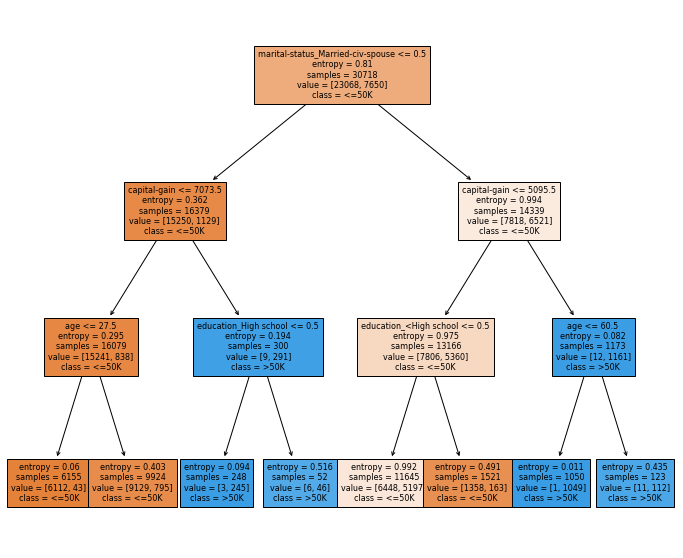

In [11]:
target_name = np.array(['<=50K', '>50K'])
feature_names = income.columns.tolist()
feature_names = feature_names[:len(income.columns.tolist())-1]

fig = plt.figure(figsize=(12,10))
tree.plot_tree(t1,  feature_names = feature_names, class_names = target_name, filled = True,fontsize =8)

(6) Train a new tree by changing a metric for finding split rules from entropy to gini impurity and compare two models in terms of the performance of the models and the generated rules

When criterion = 'entropy' the overall accuracy is  0.7975454131128329


When criterion = 'gini impurity' the overall accuracy is  0.8147991405690475


[Text(334.8, 475.65000000000003, 'marital-status_Married-civ-spouse <= 0.5\ngini = 0.374\nsamples = 30718\nvalue = [23068, 7650]\nclass = <=50K'),
 Text(167.4, 339.75, 'capital-gain <= 7073.5\ngini = 0.128\nsamples = 16379\nvalue = [15250, 1129]\nclass = <=50K'),
 Text(83.7, 203.85000000000002, 'hours-per-week <= 43.5\ngini = 0.099\nsamples = 16079\nvalue = [15241, 838]\nclass = <=50K'),
 Text(41.85, 67.94999999999999, 'gini = 0.056\nsamples = 12755\nvalue = [12384, 371]\nclass = <=50K'),
 Text(125.55000000000001, 67.94999999999999, 'gini = 0.242\nsamples = 3324\nvalue = [2857, 467]\nclass = <=50K'),
 Text(251.10000000000002, 203.85000000000002, 'education_High school <= 0.5\ngini = 0.058\nsamples = 300\nvalue = [9, 291]\nclass = >50K'),
 Text(209.25, 67.94999999999999, 'gini = 0.024\nsamples = 248\nvalue = [3, 245]\nclass = >50K'),
 Text(292.95, 67.94999999999999, 'gini = 0.204\nsamples = 52\nvalue = [6, 46]\nclass = >50K'),
 Text(502.20000000000005, 339.75, 'capital-gain <= 5095.5\ng

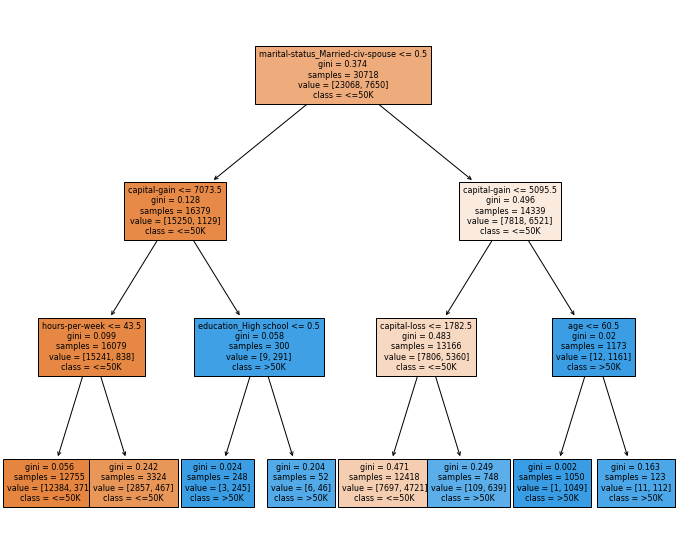

In [12]:
t2 = DecisionTreeClassifier(max_depth = 3, min_samples_split = 100, min_samples_leaf = 50)
t2.fit(X,y)

print("When criterion = 'entropy' the overall accuracy is ", t1.score(X,y))
print("\n")
print("When criterion = 'gini impurity' the overall accuracy is ", t2.score(X,y))


fig = plt.figure(figsize=(12,10))
tree.plot_tree(t2,  feature_names = feature_names, class_names = target_name, filled = True,fontsize =8)

## 3 $k$-means clustering
This problem uses the data generated from 4 normal distributions for applying $k$-means clustering. 
k-means implemented in sci-kit learn can assign initial centeroids through ‘init’. When init is set as $c$ by $p$ array ($c$ = the number of clusters, $p$ = the number of features), each row is used as a centroid.


In [13]:
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
from numpy import random

X,y=datasets.make_blobs(n_samples=500, n_features=2, cluster_std=1, random_state=68, centers=4)

(1) Select randomly 4 samples from the given data set and use them as initial centroids. This procedure is repeated for 100 times. Then, calculate the average values of the silhouette coefficient and adjusted rand index values for 100 iteration. 

In [14]:
silhouette1 = []
adjustrand1 = []
centroid1 = []
kmeans_label1 = []
TotalrandSamples1 = []

# Adjust low rand index mean worst case
for i in range(100):
    randint = random.randint(0,500,size=4)
    randSamples1 = random.normal(0,1,(4,2))
    for i in range(4):
        randSamples1[i]= X[randint[i]]
    TotalrandSamples1.append(randSamples1)   

    kmeans= KMeans(init = randSamples1, n_clusters =4, n_init=1, max_iter=100)
    kmeans.fit(X)
    kmeans_label1.append(kmeans.labels_)
    centroid1.append(kmeans.cluster_centers_)
    
    silhouette1.append(silhouette_score(X,kmeans.labels_))
    adjustrand1.append(adjusted_rand_score(y,kmeans.labels_))

print("--------- Average Value of Silhouette Coefficient for 100 times repeated---------")
print("                            ",sum(silhouette1)/len(silhouette1) )

print("\n--------- Average Value of Adjusted Rand Index for 100 times repeated---------")
print("                            ",sum(adjustrand1)/len(adjustrand1) )


--------- Average Value of Silhouette Coefficient for 100 times repeated---------
                             0.5695060889509516

--------- Average Value of Adjusted Rand Index for 100 times repeated---------
                             0.8827533178355585


(2) Select randomly one sample from each normal distribution and use them as initial centroids. This procedure is repeated for 100 times. Then, calculate the average values of the silhouette coefficient and adjusted rand index values for 100 iteration. 

In [15]:
firstND = []
secondND = []
thirdND = []
fourthND = []
for i in range(len(X)):
    if y[i] == 0:
        firstND.append(X[i])
    elif y[i] == 1:
        secondND.append(X[i])
    elif y[i] == 2:
        thirdND.append(X[i])
    else:
        fourthND.append(X[i])    

In [16]:
silhouette2 = []
adjustrand2 = []
centroid2 = []
kmeans_label2 = []
TotalrandSamples2 = []

#four find random index number of each distribution i perform like this
for i in range(100):
    randSamples2 = random.normal(0, 1,(4,2))
    
    randSamples2[0] = firstND[random.randint(0,len(firstND))]
    randSamples2[1] = secondND[random.randint(0,len(secondND))]
    randSamples2[2] = thirdND[random.randint(0,len(thirdND))]
    randSamples2[3] = fourthND[random.randint(0,len(fourthND))]
    
    TotalrandSamples2.append(randSamples2)
    kmeans= KMeans(init = randSamples2, n_clusters=4 , n_init=1, max_iter=100)
    kmeans.fit(X)

    kmeans_label2.append(kmeans.labels_)
    centroid2.append(kmeans.cluster_centers_)
    
    silhouette2.append(silhouette_score(X,kmeans.labels_))
    adjustrand2.append(adjusted_rand_score(y,kmeans.labels_))

print("--------- Average Value of Silhouette Coefficient for 100 times repeated---------")
print("                            ",sum(silhouette2)/len(silhouette2) )

print("\n--------- Average Value of Adjusted Rand Index for 100 times repeated---------")
print("                            ",sum(adjustrand2)/len(adjustrand2) )


--------- Average Value of Silhouette Coefficient for 100 times repeated---------
                             0.5928509526139325

--------- Average Value of Adjusted Rand Index for 100 times repeated---------
                             0.9405029233193548


(3) Draw a scatter plot for the given data with initial centroids and final centroids for the worst case among 100 trials in Question 3-(1). The initial centroids should be marked as red ‘X’ and the final centroids should be marked as blue ‘X’. 

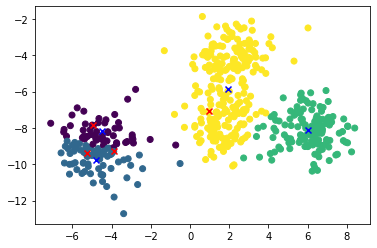

In [17]:
#According to ARI values worst case is selected
i = adjustrand1.index(min(adjustrand1))

plt.scatter(X[:,0],X[:,1],c=kmeans_label1[i])
plt.scatter(TotalrandSamples1[i][:,0],TotalrandSamples1[i][:,1], marker = 'x', c='red')
plt.scatter(centroid1[i][:,0],centroid1[i][:,1], marker = 'x', c='blue')

(37, 7)

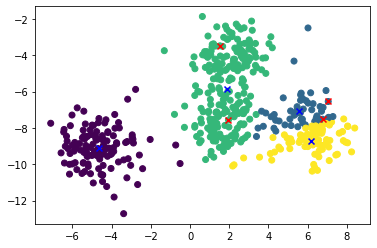

In [18]:
#According to Silhouette values worst case is selected
j = silhouette1.index(min(silhouette1))

plt.scatter(X[:,0],X[:,1],c=kmeans_label1[j])
plt.scatter(TotalrandSamples1[j][:,0],TotalrandSamples1[j][:,1], marker = 'x', c='red')
plt.scatter(centroid1[j][:,0],centroid1[j][:,1], marker = 'x', c='blue')
i,j

(4) Draw a scatter plot for the worst case of Question 3-(2) in the same way as in Question 3-(3).  

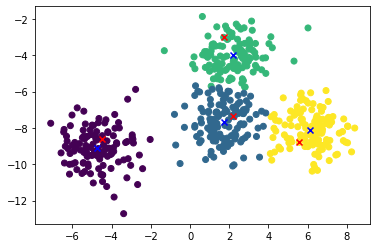

In [19]:
#According to ARI values worst case is selected
i = adjustrand2.index(min(adjustrand2))

plt.scatter(X[:,0],X[:,1],c=kmeans_label2[i])
plt.scatter(TotalrandSamples2[i][:,0],TotalrandSamples2[i][:,1], marker = 'x', c='red')
plt.scatter(centroid2[i][:,0],centroid2[i][:,1], marker = 'x', c='blue')

(4, 0)

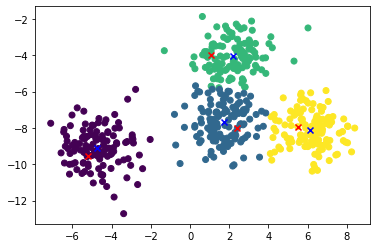

In [20]:
#According to Silhouette values worst case is selected
j = silhouette2.index(min(silhouette2))

plt.scatter(X[:,0],X[:,1],c=kmeans_label2[j])
plt.scatter(TotalrandSamples2[j][:,0],TotalrandSamples2[j][:,1], marker = 'x', c='red')
plt.scatter(centroid2[j][:,0],centroid2[j][:,1], marker = 'x', c='blue')
i,j